In [1]:
import sys
import torch
import torch.backends.cudnn as cudnn
from yolact import Yolact
from data import cfg, set_cfg, set_dataset
from torch.onnx.utils import _model_to_graph
from torch.onnx import OperatorExportTypes

Multiple GPUs detected! Turning off JIT.


In [2]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
set_cfg('yolact_plus_resnet50_config')
net = Yolact()
#net.to('cpu')
net.load_weights('weights/yolact_plus_resnet50_54_800000.pth')
net.eval()
graph, params_dict, torch_out = _model_to_graph(net, (torch.randn(1, 3, 550, 550).cuda(),), operator_export_type=OperatorExportTypes.RAW)
print(graph)

/workspace/yolact/external/DCNv2/dcn_v2.py:31: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  ctx.deformable_groups)
/workspace/yolact/yolact.py:224: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  for j, i in product(range(conv_h), range(conv_w)):
/workspace/yolact/yolact.py:248: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the t

graph(%input.1 : Float(1, 3, 550, 550),
      %1 : Float(64, 64, 1, 1),
      %2 : Float(64),
      %3 : Float(64),
      %4 : Float(64),
      %5 : Float(64),
      %6 : Long(),
      %7 : Float(64, 64, 3, 3),
      %8 : Float(64),
      %9 : Float(64),
      %10 : Float(64),
      %11 : Float(64),
      %12 : Long(),
      %13 : Float(256, 64, 1, 1),
      %14 : Float(256),
      %15 : Float(256),
      %16 : Float(256),
      %17 : Float(256),
      %18 : Long(),
      %19 : Float(256, 64, 1, 1),
      %20 : Float(256),
      %21 : Float(256),
      %22 : Float(256),
      %23 : Float(256),
      %24 : Long(),
      %25 : Float(64, 256, 1, 1),
      %26 : Float(64),
      %27 : Float(64),
      %28 : Float(64),
      %29 : Float(64),
      %30 : Long(),
      %31 : Float(64, 64, 3, 3),
      %32 : Float(64),
      %33 : Float(64),
      %34 : Float(64),
      %35 : Float(64),
      %36 : Long(),
      %37 : Float(256, 64, 1, 1),
      %38 : Float(256),
      %39 : Float(256),
      

In [55]:
from inspect import formatargspec, getfullargspec

for node in graph.nodes():
    #print(node.kind())
    if node.kind() == 'prim::PythonOp':
        print(node)
        print(node.scalar_args())
        print(node.pyname())
        print(node.cconv())
        print(list(i.debugName() for i in node.inputs()))
        break

%input.36 : Float(1, 128, 69, 69) = ^_DCNv2((2, 2), (1, 1), (1, 1), 1)(%input.35, %636, %637, %67, %68) # /workspace/yolact/external/DCNv2/dcn_v2.py:128:0

[(2, 2), (1, 1), (1, 1), 1]
_DCNv2
dddddcccc
['input.35', '636', '637', '67', '68']


In [2]:
import sys
import cv2
import rbcompiler.api_v2 as rb
import pyRbRuntime as rt
import numpy as np
import sg.dcn 

import torch
from yolact import Yolact
from data import set_cfg
from utils.augmentations import BaseTransform, FastBaseTransform, Resize

from torch.onnx.utils import _model_to_graph
from torch.onnx import OperatorExportTypes


from pytorch2sg.graph import PytorchGraph
from pytorch2sg.engine import PytorchEngine

In [14]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
set_cfg('yolact_plus_resnet50_config')
net = Yolact()
net.load_weights('weights/yolact_plus_resnet50_54_800000.pth')

net.eval()

# run torch  
img_path = './data/3.jpg'
img_1 = torch.from_numpy(cv2.imread(img_path)).cuda().float()
img = FastBaseTransform()(img_1.unsqueeze(0))
print(img.shape)
preds = net(img)

torch.Size([1, 3, 550, 550])


In [45]:
print(np.min(preds['loc'].cpu().detach().numpy()), np.max(preds['loc'].cpu().detach().numpy()))

-10.836867 3.510693
[[[-0.63175654 -0.31528127 -5.7913256  -6.268593  ]
  [-0.25990513 -0.10613597 -4.6111913  -6.3442817 ]
  [-0.28843403 -0.41684425 -4.573845   -4.436427  ]
  ...
  [-0.06151865 -0.12370781 -1.000965   -1.3296962 ]
  [ 0.02105898 -0.12049096 -0.25856274 -1.6291595 ]
  [-0.10935113 -0.07686739 -1.1678096  -1.0518204 ]]]


In [4]:
out = net.detect(preds, net)

In [5]:
from eval import prep_display

img_numpy = prep_display(out, img_1, None, None, undo_transform=False)

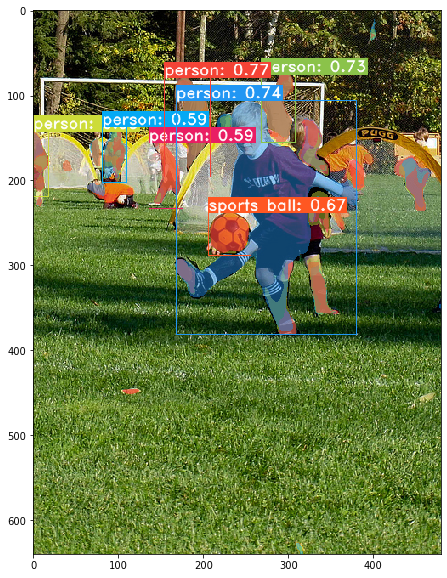

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

img_numpy = img_numpy[:, :, (2, 1, 0)]
plt.figure(figsize=(10,10))
plt.imshow(img_numpy)
plt.show()

In [15]:
# # run runtime
rb_net = rt.Network('./sg/yolact_plus.sg', dp=[rt.GPU])
outputs = rb_net.Run(img.cpu().detach().numpy().astype(np.float32))
print(outputs.keys())

dict_keys(['1630', '1603', '2001', '2005', '1995', '1449', '1468'])


In [42]:
print(np.min(outputs['1995']), np.max(outputs['1995']))

-10.836867 3.510693


In [16]:
preds['loc'] = torch.from_numpy(outputs['1995']).cuda().float()
preds['conf'] = torch.from_numpy(outputs['2005']).cuda().float()
preds['mask'] = torch.from_numpy(outputs['2001']).cuda().float()
out = net.detect(preds, net)
img_numpy = prep_display(out, img_1, None, None, undo_transform=False)

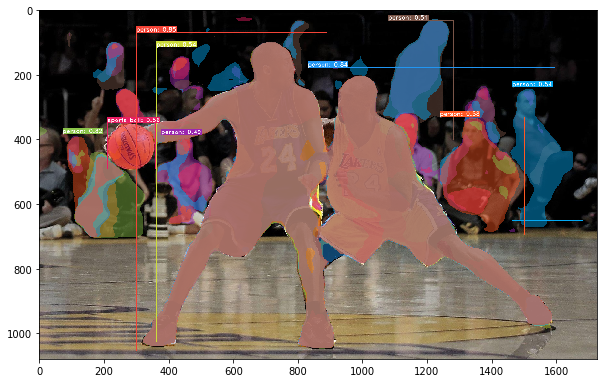

In [17]:
img_numpy = img_numpy[:, :, (2, 1, 0)]
plt.figure(figsize=(10,10))
plt.imshow(img_numpy)
plt.show()